In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import re, unicodedata
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import train_test_split

In [3]:
combined_data = pd.read_csv('/content/drive/MyDrive/Python_Training/ModuleA_Project/combined_data.csv')
word_vector = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Python_Training/ModuleA_Project/vulner_embedding.bin", binary=True)
combined_data

,cve_id,report,exploitabilityScore,impactScore,baseScore
0,CVE-1999-0001,ip_input.c in BSD-derived TCP/IP implementatio...,10.0,2.9,5.0
1,CVE-1999-0002,Buffer overflow in NFS mountd gives root acces...,10.0,10.0,10.0
2,CVE-1999-0003,Execute commands as root via buffer overflow i...,10.0,10.0,10.0
3,CVE-1999-0004,"MIME buffer overflow in email clients, e.g. So...",10.0,2.9,5.0
4,CVE-1999-0005,Arbitrary command execution via IMAP buffer ov...,10.0,10.0,10.0
...,...,...,...,...,...
180041,CVE-2022-35648,Nautilus treadmills T616 S/N 100672PRO21140001...,3.9,2.9,2.1
180042,CVE-2022-35861,pyenv 1.2.24 through 2.3.2 allows local users ...,3.9,6.4,4.6
180043,CVE-2022-36728,Library Management System v1.0 was discovered ...,10.0,6.4,7.5
180044,CVE-2022-36880,The Read Mail module in Webmin 1.995 and Userm...,8.6,2.9,4.3


##extract data

In [8]:
def process_report(report):
    report = report.lower()
    report = re.sub("<!--?.*?-->", "", report)
    report = unicodedata.normalize('NFKD', report).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    report= re.sub("(\\d|\\W)+"," ",report)
    report = re.sub('[^a-zA-z0-9\s]', "", report)
    sentences = [sentence for sentence in report.split() if sentence in word_vector]
    return sentences


def feautures_extractor(report):
  sentences = process_report(report)
  vectors = [word_vector[sentence] for sentence in sentences]
  avg_vectors = np.mean(vectors, axis=0)
  return avg_vectors


def extract_data(df):
  avg_vectors = []
  for idx in range(df.shape[0]):
    avg_vector = feautures_extractor(df['report'][idx])
    avg_vectors.append(avg_vector)

  features_df = pd.DataFrame(avg_vectors)
  exploitabilityScore_df = pd.DataFrame(df['exploitabilityScore'].tolist())
  impactScore_df = pd.DataFrame(df['impactScore'].tolist())
  X = pd.concat([exploitabilityScore_df, impactScore_df, features_df], axis=1)
  X.columns = ['exploitabilityScore', 'impactScore'] + list(features_df.columns)
  y = df['baseScore'].apply(lambda x: 0 if int(x) < 6.0 else 1)
  return X, y

In [10]:
X, y = extract_data(combined_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train

,exploitabilityScore,impactScore,0,1,2,3,4,5,6,7,...,140,141,142,143,144,145,146,147,148,149
42355,8.6,2.9,0.261198,-0.048812,-0.023498,-0.078731,-0.157355,-0.267589,0.109080,0.041922,...,0.133470,0.257303,-0.094424,-0.201710,-0.101954,-0.020214,-0.142973,0.180447,0.330599,0.315055
54067,6.5,2.9,0.050426,0.207876,-0.227967,-0.156760,-0.135879,-0.219082,-0.194340,0.062412,...,0.067946,0.388062,0.005962,-0.232988,0.067439,-0.207690,-0.159939,0.189394,0.229561,0.102887
138726,10.0,2.9,0.140639,0.080047,-0.232932,-0.253900,-0.158215,-0.199670,-0.003107,0.032982,...,0.138007,0.215783,-0.070037,-0.151692,-0.028963,-0.125536,-0.210404,0.055958,0.204427,0.134870
35347,10.0,6.4,0.176138,-0.033371,-0.087762,-0.094294,-0.063682,-0.148988,0.065928,0.016202,...,0.074319,0.319245,-0.015663,-0.167573,0.010372,-0.136113,-0.009765,0.151464,0.403636,0.111383
92487,8.6,2.9,0.111233,-0.068663,-0.324575,-0.069076,-0.171482,-0.180026,0.000061,-0.126603,...,0.125366,0.156870,-0.006910,-0.115205,-0.063939,0.070332,-0.173428,0.131427,0.364712,0.245028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,10.0,2.9,0.106668,-0.024301,-0.262356,-0.086226,-0.121065,-0.202623,-0.068415,0.058877,...,0.020311,0.213135,0.032276,-0.089351,0.007532,-0.024083,-0.158165,0.266331,0.244814,0.139975
103694,8.0,6.4,0.057466,0.059572,-0.219625,-0.071327,-0.057892,-0.094547,-0.016746,0.024829,...,0.040852,0.258731,0.027055,-0.167712,-0.029705,-0.028580,-0.201816,0.104347,0.232407,0.263863
131932,3.9,10.0,0.072285,0.077558,-0.196075,-0.155085,-0.130646,-0.052278,-0.028417,0.028709,...,-0.011602,0.202184,0.067900,-0.139079,-0.145349,-0.091700,-0.094293,0.111592,0.299524,0.169652
146867,8.0,2.9,-0.055092,0.060996,-0.283890,-0.314631,-0.064044,-0.235950,-0.108685,0.065721,...,0.007001,0.223416,-0.162386,-0.056635,0.024415,-0.067374,-0.231825,0.424065,0.289715,0.224395


## train module

In [11]:
from keras import Sequential
from keras.layers import Input, Dense, Dropout, Conv1D,  GlobalMaxPooling1D
from keras.optimizers import Adam
from keras import metrics
import tensorflow as tf

In [12]:
X_train.shape[1]

152

In [13]:
input_shape = (X_train.shape[1],1)
model = Sequential([
    Input(shape=input_shape),
    Conv1D(filters=256, kernel_size=3, activation="relu"),
    Conv1D(filters=128, kernel_size=3, activation="relu"),
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.01, beta_1=0.5),
    metrics=[metrics.BinaryAccuracy(), metrics.Precision(), metrics.Recall()]
)

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=10000,
    validation_data=(X_test, y_test)
)

Epoch 1/10
13/13 [==============================] - 505s 38s/step - loss: 0.8281 - binary_accuracy: 0.6632 - precision: 0.6278 - recall: 0.6855 - val_loss: 0.4459 - val_binary_accuracy: 0.8947 - val_precision: 0.8329 - val_recall: 0.9671
Epoch 2/10
13/13 [==============================] - 455s 35s/step - loss: 0.3315 - binary_accuracy: 0.8776 - precision: 0.8237 - recall: 0.9390 - val_loss: 0.2369 - val_binary_accuracy: 0.8924 - val_precision: 0.8117 - val_recall: 1.0000
Epoch 3/10
13/13 [==============================] - 457s 36s/step - loss: 0.3497 - binary_accuracy: 0.8602 - precision: 0.8030 - recall: 0.9286 - val_loss: 0.2777 - val_binary_accuracy: 0.8408 - val_precision: 0.7445 - val_recall: 1.0000
Epoch 4/10
13/13 [==============================] - 457s 36s/step - loss: 0.2401 - binary_accuracy: 0.8939 - precision: 0.8231 - recall: 0.9845 - val_loss: 0.1165 - val_binary_accuracy: 0.9699 - val_precision: 0.9725 - val_recall: 0.9623
Epoch 5/10
13/13 [==============================

## evaluate module

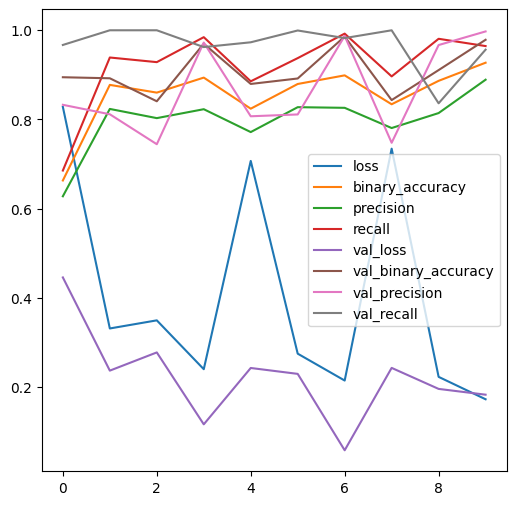

In [14]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(6, 6))
plt.legend()

In [15]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [16]:
loss, binary_accuracy, precision, recall = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred > 0.5)
print("Test loss:", loss)
print("Test binary accuracy:", binary_accuracy)
print("Test precision:", precision)
print("Test recall:", recall)
print("Test F1-score:", f1)

1688/1688 [==============================] - 50s 29ms/step
Test loss: 0.18298830091953278
Test binary accuracy: 0.9786906838417053
Test precision: 0.9974201321601868
Test recall: 0.9565425515174866
Test F1-score: 0.9765537471226906


In [17]:
y_pred = np.round(y_pred)

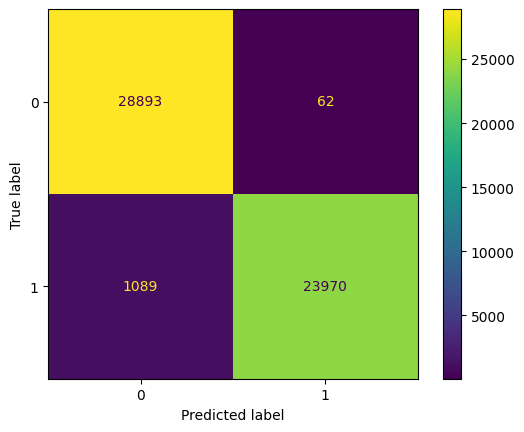

In [18]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()